In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image
import numpy as np
#import gdown
from tqdm import tqdm
import matplotlib.pyplot as plt

如何理解 CNN on Deepseek https://chat.deepseek.com/share/hr7spr0zmlvv91z2od

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Fri Nov  7 19:18:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              6W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
#!git clone https://github.com/steven-lunar/GenAI-ML-HW6.git
%cd ./GenAI-ML-HW6/

c:\enlist\LLMLearning\GenAICourse\GenAI-ML-HW6


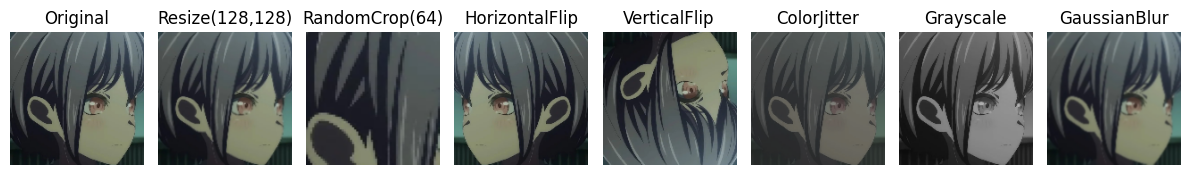

In [6]:
img_path = "./train/0.png"
img = Image.open(img_path).convert("RGB")

transform_list = {
    "Original": transforms.Compose([]),
    "Resize(128,128)": transforms.Resize((128, 128)),
    "RandomCrop(64)": transforms.RandomCrop(64),
    "HorizontalFlip": transforms.RandomHorizontalFlip(p=1.0),
    "VerticalFlip": transforms.RandomVerticalFlip(p=1.0),
    "ColorJitter": transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    "Grayscale": transforms.Grayscale(num_output_channels=3),
    "GaussianBlur": transforms.GaussianBlur(kernel_size=9)
}

n = len(transform_list)
plt.figure(figsize=(12, 3))
for i, (name, t) in enumerate(transform_list.items()):
    transformed_img = t(img)
    plt.subplot(1, n, i + 1)
    plt.imshow(transformed_img)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
label2class = {
    "anon": 0,
    "mutsumi": 1,
    "nyamuchi": 2,
    "rana": 3,
    "sakiko": 4,
    "soyo": 5,
    "taki": 6,
    "tomori": 7,
    "uika": 8,
    "umiri": 9
    ## "mana": 10   ...only appears in few sences...
}

In [78]:
class MyGOCharacterDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None):
        """
        Args:
            json_path (str): Path to the json file with the metadata for this dataset (eg. train.json, valid.json, test.json)
            images_dir (str): Path to the images directory (eg. ./train/)
            transform (callable, optional): The transformation set you create (train_transform)
        """
        self.images_dir = images_dir
        self.transform = transform

        ## load metadata
        with open(json_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        attr = self.metadata[idx]
        img_path = os.path.join(self.images_dir, attr['filename'])
        idx = attr["id"]
        ## Images are opened with RGB channels, 3 channels
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            ## If there is transformations defined, we implement these transformations on our images
            image = self.transform(image)

        if "test" in self.images_dir:
            ## No label for the testing set, so we don't return labels
            return image, idx
        else:
            label = attr['label']
            label = label2class[label]
            return image, label, idx

In [89]:
train_transform = transforms.Compose([
    ## We resize all images to a specific size, 128 * 128 here
    ## You can resize them into other size, yet you may need to modify the architecture of model to fit the input shape
    transforms.Resize((128, 128)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),

    ## TODO: You may using test-time augmentation here (not necessary if you only want to pass all baselines)
    ## You can implement it if you want.
    transforms.ToTensor(),
])

In [90]:
train_set = MyGOCharacterDataset(
    json_path='./train/train.json',
    images_dir='./train',
    transform=train_transform
)

val_set = MyGOCharacterDataset(
    json_path='./valid/valid.json',
    images_dir='./valid',
    transform=train_transform
)

test_set = MyGOCharacterDataset(
    json_path='./test/test.json',
    images_dir='./test',
    transform=test_transform
)

In [11]:
class MyLinearModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: You may modify the linear model here to archieve better performance
        self.simple_linear = nn.Sequential(
            nn.Flatten(),                  # Flatten the image data into a 1D-vector
            nn.Linear(128 * 128 * 3, 4096),       # Fully-connected layer
            nn.ReLU(),                    # Activation function, ReLU here, can change it with other functions
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)          # Using linear layer to map output with number of classes, 10
        )

    def forward(self, x):
        return self.simple_linear(x)

In [13]:
## You can change the directory for saving the model weight
save_dir = "./linear/"
os.makedirs(save_dir, exist_ok=True)  # To create the saving directory

In [14]:
seed = 42   # You may change random seed here
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [29]:
def print_info(num_epochs, train_losses, val_losses, train_accs,val_accs ):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Validation Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    import glob
    for path in glob.glob(f"{save_dir}/*.pth"):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print("Your model size:")
        print(f"{path}: {size_mb:.2f} MB")

In [92]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: Modify the CNN architecture here to get better performance
        ## - Wider
        ## - Deeper
        ## - Not so much downsample to preserve more information in the images (i.e. adjust the kernal size)
        ## - Dropout (nn.Dropout(p), reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


        ## Pay attention to the input shape, it may not suit your modified model!!
        ## The default input shape here is [batch_size, 128, 128, 3]
        self.simple_CNN = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1), 
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Dropout(0.4),  # 全连接前较大的Dropout
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.25),  # 0.2 → 0.25
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),  # 保持或微调
            nn.Linear(256, num_classes)
        )


        ## TODO: You may use the pre-defined model in this task
        ## You may choose the pre-defined model for yourself
        ## Useful pre-defined model list: https://docs.pytorch.org/vision/main/models.html
        ## Maybe pre-trained weight?

        ## Example:
        ## self.resnet18 = torchvision.models.resnet18(pretrained=False)

        ## You still need to modify the forward() function below to use these pre-defined models on the image
        ## Remember to check the input and output shape of these pre-defined models!

    def forward(self, x):
        return self.simple_CNN(x)

In [24]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs=20, print_interval = 10, criterion=None, save_dir='./models'):
    """
    训练模型
    
    Args:
        model: 要训练的模型
        optimizer: 优化器
        num_epochs: 训练轮数，默认为20
        criterion: 损失函数，默认为交叉熵损失
        save_dir: 模型保存目录
    
    Returns:
        dict: 包含训练过程和最佳结果的字典
    """
    # 设置默认损失函数
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    
    # 初始化记录变量
    best_epoch = 0
    best_val_acc = 0
    best_train_acc = 0
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_model_state = None
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # 训练循环
    for epoch in range(num_epochs):
        model.train()  # 设置为训练模式
        
        train_loss = 0
        train_correct = 0
        
        # 训练阶段
        for images, labels, idx in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        # 计算训练损失和准确率
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)
        #print(f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2%}")
        
        # 验证阶段
        val_correct = 0
        val_loss = 0
        model.eval()  # 设置为评估模式
        
        with torch.no_grad():
            for images, labels, idx in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_set)
        #print(f"Valid Loss={avg_val_loss:.4f}, Valid Acc={val_acc:.2%}")
        
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_train_loss = avg_train_loss
        
        if avg_train_loss > best_train_loss:
            print(f'Find good loss with bad acc in epoch {epoch}')
        
        if (epoch + 1) % print_interval  == 0:
            print("\n" + "="*50)
            print(f"训练进度汇总 - 第 {epoch + 1} 轮, 当前最佳训练损失: {best_train_loss:.4f},当前最佳训练准确率: {best_train_acc:.2%},当前最佳验证损失: {best_val_loss:.4f},当前最佳验证准确率: {best_val_acc:.2%}")
            print("="*50 + "\n")

        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            save_path = os.path.join(save_dir, 'best_model.pth')
            torch.save(best_model_state, save_path)
            print("Model saved (best validation acc.)")
        
        # 记录训练过程
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
    # 返回训练过程和最佳结果
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_epoch':best_epoch,
        'best_val_acc': best_val_acc,
        'best_train_acc': best_train_acc,
        'best_val_loss' : best_val_loss,
        'best_train_loss' : best_train_loss,
        'best_model_state': best_model_state,
        'final_model_state': model.state_dict()
    }

Model saved (best validation acc.)
Model saved (best validation acc.)
Model saved (best validation acc.)
Find good loss with bad acc in epoch 5
Model saved (best validation acc.)
Find good loss with bad acc in epoch 9

训练进度汇总 - 第 10 轮, 当前最佳训练损失: 2.0387,当前最佳训练准确率: 30.80%,当前最佳验证损失: 2.0057,当前最佳验证准确率: 36.00%

Model saved (best validation acc.)
Model saved (best validation acc.)
Model saved (best validation acc.)
Find good loss with bad acc in epoch 14
Model saved (best validation acc.)

训练进度汇总 - 第 20 轮, 当前最佳训练损失: 1.9688,当前最佳训练准确率: 33.65%,当前最佳验证损失: 1.8603,当前最佳验证准确率: 46.00%

Find good loss with bad acc in epoch 21
Find good loss with bad acc in epoch 22
Find good loss with bad acc in epoch 23
Find good loss with bad acc in epoch 28
Model saved (best validation acc.)

训练进度汇总 - 第 30 轮, 当前最佳训练损失: 1.8600,当前最佳训练准确率: 36.88%,当前最佳验证损失: 1.7862,当前最佳验证准确率: 47.00%

Find good loss with bad acc in epoch 35
Model saved (best validation acc.)

训练进度汇总 - 第 40 轮, 当前最佳训练损失: 1.8154,当前最佳训练准确率: 40.30%,当前最佳验证损失: 1.

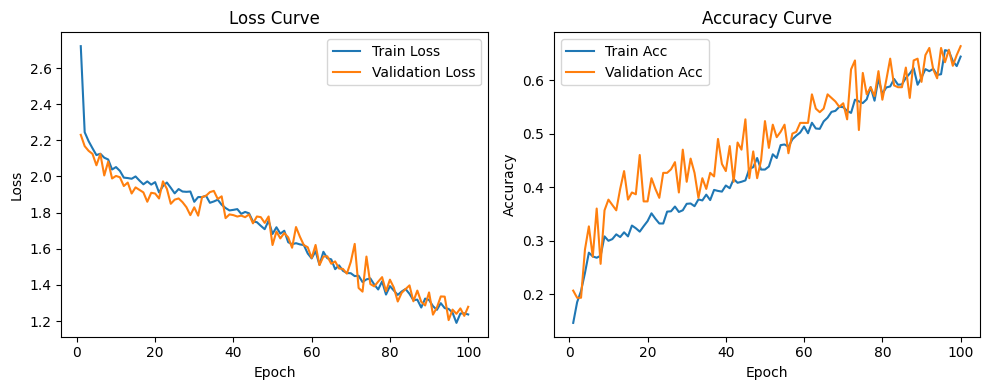

Your model size:
./CNN_models\best_model.pth: 38.68 MB


In [93]:
batch_size = 32
num_epochs = 100
learning_rate = 2e-3
weight_decay = 5e-4
model = MyCNNModel().to(device) # MyLinearModel MyCNNModel
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
save_dir = './CNN_models'

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

result = train_model(model, optimizer, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, print_interval = 10, save_dir=save_dir)
print(f"best train acc:{result['best_train_acc']:.2%}, best val acc:{result['best_val_acc']:.2%}, best_epoch:{result['best_epoch']}")
print_info(num_epochs, result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'])

def 智能调参(训练acc, 验证acc, 当前配置):
    差距 = 训练acc - 验证acc
    
    if 训练acc < 80%:
        # 欠拟合优先
        return "增加模型能力：↑层数 ↑通道数 ↑学习率 ↓Dropout"
    
    elif 差距 > 10%:
        # 严重过拟合  
        return "强正则化：↑Dropout ↑WeightDecay ↑数据增强"
    
    elif 差距 > 5%:
        # 轻微过拟合
        return "微调：轻微↑Dropout 轻微↑数据增强"
    
    else:
        # 平衡状态
        return "保持配置，尝试集成或继续训练"

batch_size = 32
num_epochs = 20
learning_rate = 2e-4
best train acc:71.23%, best val acc:64.33%, best_epoch:18

batch_size = 32
num_epochs = 30
learning_rate = 2e-3
best train acc:97.59%, best val acc:80.67%, best_epoch:29

___________________________
增加dropout
batch_size = 32
num_epochs = 30
learning_rate = 2e-3
best train acc:69.20%, best val acc:69.67%, best_epoch:25

线性模型的效果，作为基准模型。

Model saved (best validation acc.)
Model saved (best validation acc.)
Model saved (best validation acc.)
Model saved (best validation acc.)

训练进度汇总 - 第 10 轮, 当前最佳训练损失: 1.5761,当前最佳训练准确率: 46.96%,当前最佳验证损失: 1.7038,当前最佳验证准确率: 44.33%

Model saved (best validation acc.)
Model saved (best validation acc.)

训练进度汇总 - 第 20 轮, 当前最佳训练损失: 1.1175,当前最佳训练准确率: 62.67%,当前最佳验证损失: 1.5403,当前最佳验证准确率: 50.67%

Model saved (best validation acc.)
best train acc:62.67%, best val acc:55.33%, best_epoch:19


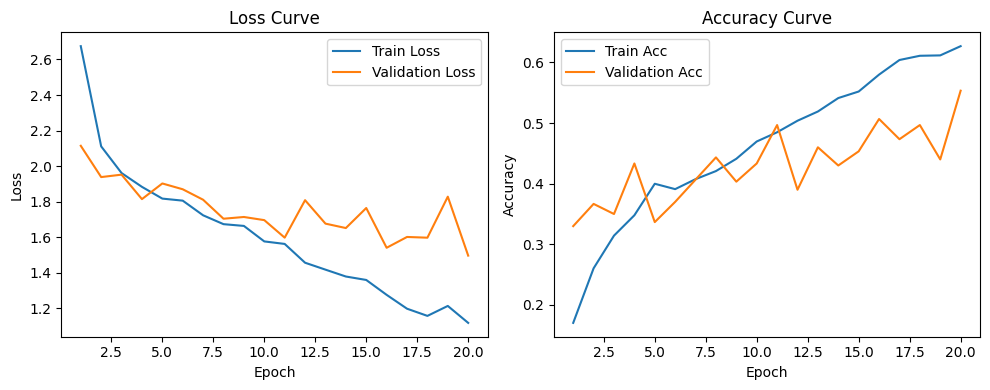

Your model size:
./CNN_models\best_model.pth: 776.04 MB


In [30]:
batch_size = 32
num_epochs = 20
learning_rate = 2e-4
weight_decay = 1e-5
model = MyLinearModel().to(device) # MyLinearModel MyCNNModel
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
save_dir = './CNN_models'

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

result = train_model(model, optimizer, train_loader, val_loader, num_epochs=num_epochs, criterion=criterion, print_interval = 10, save_dir=save_dir)
print(f"best train acc:{result['best_train_acc']:.2%}, best val acc:{result['best_val_acc']:.2%}, best_epoch:{result['best_epoch']}")
print_info(num_epochs, result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'])

best train acc:71.23%, best val acc:64.33%, best_epoch:18


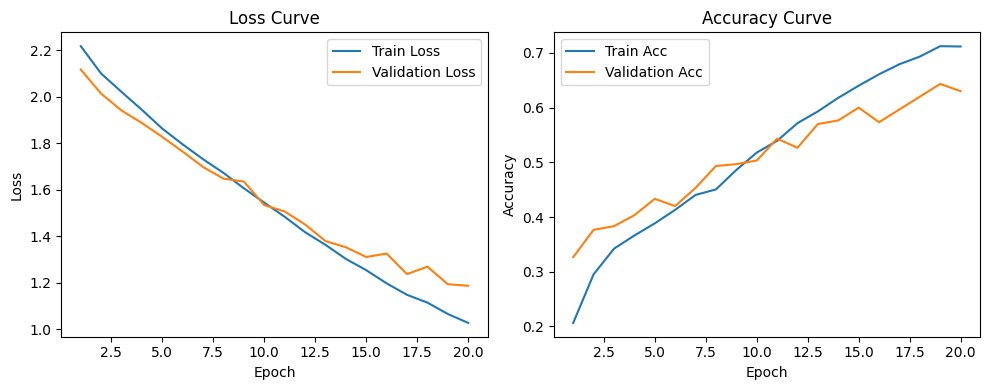

Your model size:
./CNN_models\best_model.pth: 0.11 MB


In [28]:
print(f"best train acc:{result['best_train_acc']:.2%}, best val acc:{result['best_val_acc']:.2%}, best_epoch:{result['best_epoch']}")
print_info(num_epochs, result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'])